# Test for Zeroth Order Methods

This file tests the zeroth order methods to ensure they are functioning.

### Imports

In [1]:
import os
import sys

p = os.path.abspath('../')
if p not in sys.path:
    sys.path.append(p)

In [2]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt

from difference_methods import one_point_estimate, two_point_estimate, coordinate_estimate
from linear_zeroth_function import Linear_Zeroth
from sigmoid_zeroth_function import Sigmoid_Zeroth
from relu_zeroth_function import ReLU_Zeroth

## Test Difference Methods

Test using ```torch.nn.functional.linear```, ```torch.sigmoid``` and ```torch.nn.functional.relu``` as the functions to differentiate:

In [3]:
# Setup testing functions
weight = torch.Tensor([[1.0,-2.0],[-3.0,4.0],[5.0,-6.0]])
bias = torch.Tensor([[2.5, 0.0, -2.5]])
test_f_0 = lambda x: torch.nn.functional.linear(x, weight, bias)

test_f_1 = torch.sigmoid

test_f_2 = torch.nn.functional.relu

# Setup values
fs = [test_f_0, test_f_1, test_f_2]
xs = [torch.Tensor([[0.0, 0.0]]), torch.Tensor([[0.0, 0.0], [1.0, -2.5]])]
methods = [('one', one_point_estimate), ('two', two_point_estimate), ('coord', coordinate_estimate)]
mus = [0.1] #, 2.0]
ns = [1000] #, 100]

# Iterate over values
for i, f in enumerate(fs):
    print(f"test_f_{i}\n========")
    for x in xs:
        print(f"{x = }\n---------")
        # o = f(x)
        # print(o)
        for name, method in methods:
            for mu in mus:
                if name == 'coord':
                    estimate = method(f, x, mu)
                    print(f"{name}({mu}) = {estimate}")
                else:
                    for n in ns:
                        estimate = method(f, x, mu, n)
                        print(f"{name}({mu},{n}) = {estimate}")
        print(f"---------")
    if i < 2:
        print("")

test_f_0
x = tensor([[0., 0.]])
---------
one(0.1,1000) = tensor([[ 2.8283, -3.6687]])
two(0.1,1000) = tensor([[ 3.0287, -4.1361]])
coord(0.1) = tensor([[ 3.0000, -4.0000]])
---------
x = tensor([[ 0.0000,  0.0000],
        [ 1.0000, -2.5000]])
---------
one(0.1,1000) = tensor([[12.3443,  0.0857],
        [ 5.3312, -0.7146]])
two(0.1,1000) = tensor([[ 3.6012, -4.8252],
        [ 3.1328, -4.8528]])
coord(0.1) = tensor([[ 3.0000, -4.0000],
        [ 3.0000, -4.0000]])
---------

test_f_1
x = tensor([[0., 0.]])
---------
one(0.1,1000) = tensor([[0.4089, 0.4644]])
two(0.1,1000) = tensor([[0.2539, 0.2431]])
coord(0.1) = tensor([[0.2498, 0.2498]])
---------
x = tensor([[ 0.0000,  0.0000],
        [ 1.0000, -2.5000]])
---------
one(0.1,1000) = tensor([[ 0.3966,  1.2374],
        [-0.0736, -0.2961]])
two(0.1,1000) = tensor([[0.2910, 0.2855],
        [0.2429, 0.0550]])
coord(0.1) = tensor([[0.2498, 0.2498],
        [0.1920, 0.0731]])
---------

test_f_2
x = tensor([[0., 0.]])
---------
one(0.1,

## Test Zeroth Order Modules and Functions

We create a small and simple neural network to test the functionality of the zeroth order variants of the linear, sigmoid, and relu modules/functions. We run a quick test on the flower dataset.

### Data

In [4]:
# load training data
data_train = pd.read_csv('iris_train.csv')

print(data_train)

     sepal_length  sepal_width  petal_length  petal_width          species
0             5.1          3.4           1.5          0.2      Iris-setosa
1             6.3          2.5           5.0          1.9   Iris-virginica
2             5.9          3.0           4.2          1.5  Iris-versicolor
3             5.7          2.6           3.5          1.0  Iris-versicolor
4             7.7          2.8           6.7          2.0   Iris-virginica
..            ...          ...           ...          ...              ...
115           5.6          2.5           3.9          1.1  Iris-versicolor
116           6.4          2.9           4.3          1.3  Iris-versicolor
117           7.9          3.8           6.4          2.0   Iris-virginica
118           5.4          3.0           4.5          1.5  Iris-versicolor
119           5.5          3.5           1.3          0.2      Iris-setosa

[120 rows x 5 columns]


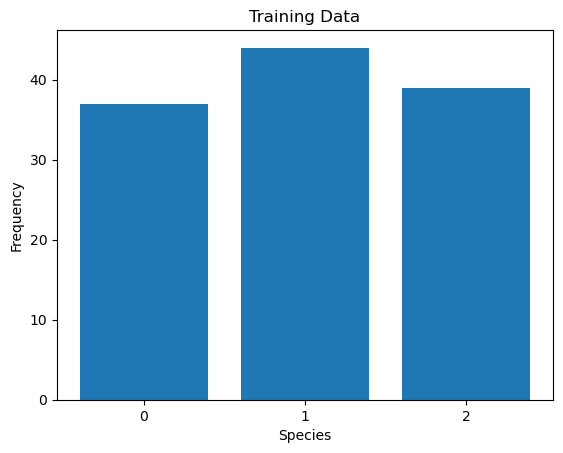

In [5]:
# convert string target values to numeric values
#       class 0: Iris-setosa
#       class 1: Iris-versicolor
#       class 2: Iris-virginica
data_train['species'] = data_train['species'].map({'Iris-setosa': 0, 'Iris-versicolor': 1, 'Iris-virginica': 2})

# also convert all string numeric values to int ['2' -> 2]
data_train = data_train.apply(pd.to_numeric)

# extract frequency of each species class
class_freq = data_train['species'].value_counts()
class_freq = list(class_freq.sort_index())

# Visual data
graph = plt.bar(list(range(0,3)), class_freq)
plt.xticks(list(range(0,3)))
plt.ylabel('Frequency')
plt.xlabel('Species')
plt.title('Training Data')

plt.show()

In [6]:
# Process data for training

# convert pandas dataframe to array
data_train_array = data_train.values

# split x (features) and y (targets)
x_array = data_train_array[:, :4]
y_array = data_train_array[:, 4]

# tensorify
X = torch.tensor(x_array, dtype=torch.float)
Y = torch.tensor(y_array, dtype=torch.long)

print(X.shape)

torch.Size([120, 4])


### Network Setup

In [7]:
# Standard Constants
INPUT_NEURONS = 4
HIDDEN_NEURONS = 10
OUTPUT_NEURONS = 3

# Zeroth Constants
DIFFERENCE_METHOD = 'coord'
MU = 0.001
N = 100

In [8]:
# Linear Networks

# Normal
standard_linear = torch.nn.Sequential(
    torch.nn.Linear(INPUT_NEURONS, OUTPUT_NEURONS),
)
# Zeroth Order
linear_test = torch.nn.Sequential(
    Linear_Zeroth(INPUT_NEURONS, OUTPUT_NEURONS, bias=False, difference_method=DIFFERENCE_METHOD, mu=MU, n=N)
)

# Sigmoid

# Normal network
standard_sigmoid = torch.nn.Sequential(
    torch.nn.Linear(INPUT_NEURONS, HIDDEN_NEURONS),
    torch.nn.Sigmoid(),
    torch.nn.Linear(HIDDEN_NEURONS, OUTPUT_NEURONS)
)
# Zeroth Order only sigmoid
partial_sigmoid = torch.nn.Sequential(
    torch.nn.Linear(INPUT_NEURONS, HIDDEN_NEURONS),
    Sigmoid_Zeroth(difference_method=DIFFERENCE_METHOD, mu=MU, n=N),
    torch.nn.Linear(HIDDEN_NEURONS, OUTPUT_NEURONS)
)
# Full Zeroth Order
zeroth_sigmoid = torch.nn.Sequential(
    Linear_Zeroth(INPUT_NEURONS, HIDDEN_NEURONS, bias=False, difference_method=DIFFERENCE_METHOD, mu=MU, n=N),
    Sigmoid_Zeroth(difference_method=DIFFERENCE_METHOD, mu=MU, n=N),
    Linear_Zeroth(HIDDEN_NEURONS, OUTPUT_NEURONS, bias=False, difference_method=DIFFERENCE_METHOD, mu=MU, n=N)
)

# ReLU

# Normal network
standard_relu = torch.nn.Sequential(
    torch.nn.Linear(INPUT_NEURONS, HIDDEN_NEURONS),
    torch.nn.ReLU(),
    torch.nn.Linear(HIDDEN_NEURONS, OUTPUT_NEURONS)
)
# Zeroth Order only ReLU
partial_relu = torch.nn.Sequential(
    torch.nn.Linear(INPUT_NEURONS, HIDDEN_NEURONS),
    ReLU_Zeroth(difference_method=DIFFERENCE_METHOD, mu=MU, n=N),
    torch.nn.Linear(HIDDEN_NEURONS, OUTPUT_NEURONS)
)
# Full Zeroth Order
zeroth_relu = torch.nn.Sequential(
    Linear_Zeroth(INPUT_NEURONS, HIDDEN_NEURONS, bias=False, difference_method=DIFFERENCE_METHOD, mu=MU, n=N),
    ReLU_Zeroth(difference_method=DIFFERENCE_METHOD, mu=MU, n=N),
    Linear_Zeroth(HIDDEN_NEURONS, OUTPUT_NEURONS, bias=False, difference_method=DIFFERENCE_METHOD, mu=MU, n=N),
)

networks = [
    ("standard_linear", standard_linear),
    ("linear_test", linear_test),

    ("standard_sigmoid", standard_sigmoid),
    ("partial_sigmoid", partial_sigmoid),
    ("zeroth_sigmoid", zeroth_sigmoid),

    ("standard_relu", standard_relu),
    ("partial_relu", partial_relu),
    ("zeroth_relu", zeroth_relu),
]

### Train and Plot Losses

Network: standard_linear
Epoch [1 / 500] Loss: 2.7918  Accuracy: 4.17 %
Epoch [51 / 500] Loss: 1.0512  Accuracy: 36.67 %
Epoch [101 / 500] Loss: 0.8230  Accuracy: 66.67 %
Epoch [151 / 500] Loss: 0.6983  Accuracy: 87.50 %
Epoch [201 / 500] Loss: 0.6245  Accuracy: 90.83 %
Epoch [251 / 500] Loss: 0.5758  Accuracy: 94.17 %
Epoch [301 / 500] Loss: 0.5408  Accuracy: 95.00 %
Epoch [351 / 500] Loss: 0.5138  Accuracy: 95.00 %
Epoch [401 / 500] Loss: 0.4919  Accuracy: 95.00 %
Epoch [451 / 500] Loss: 0.4735  Accuracy: 95.83 %


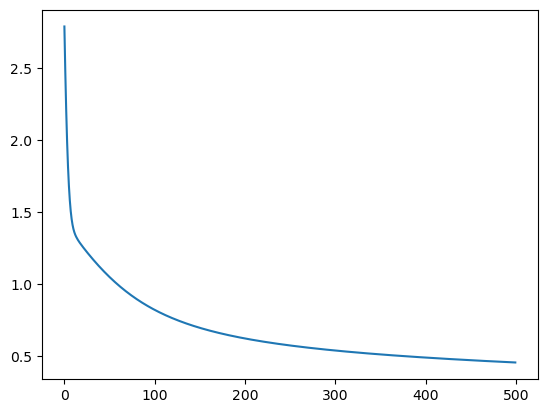

Network: linear_test
Epoch [1 / 500] Loss: 2.0500  Accuracy: 32.50 %
Epoch [51 / 500] Loss: 1.8632  Accuracy: 32.50 %
Epoch [101 / 500] Loss: 1.7362  Accuracy: 32.50 %
Epoch [151 / 500] Loss: 1.6602  Accuracy: 60.00 %
Epoch [201 / 500] Loss: 1.6197  Accuracy: 62.50 %
Epoch [251 / 500] Loss: 1.6009  Accuracy: 57.50 %
Epoch [301 / 500] Loss: 1.5945  Accuracy: 42.50 %
Epoch [351 / 500] Loss: 1.5947  Accuracy: 34.17 %
Epoch [401 / 500] Loss: 1.5979  Accuracy: 32.50 %
Epoch [451 / 500] Loss: 1.6022  Accuracy: 32.50 %


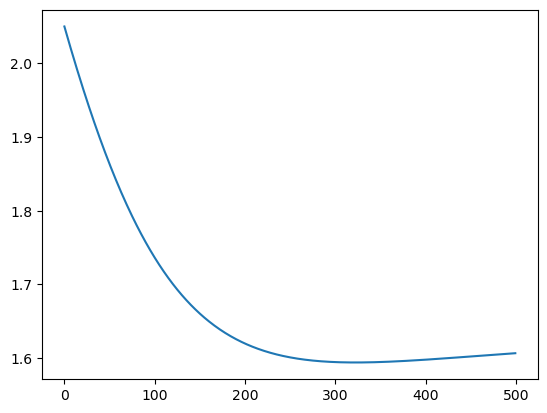

Network: standard_sigmoid
Epoch [1 / 500] Loss: 1.0651  Accuracy: 32.50 %
Epoch [51 / 500] Loss: 1.0341  Accuracy: 32.50 %
Epoch [101 / 500] Loss: 1.0121  Accuracy: 41.67 %
Epoch [151 / 500] Loss: 0.9921  Accuracy: 59.17 %
Epoch [201 / 500] Loss: 0.9722  Accuracy: 66.67 %
Epoch [251 / 500] Loss: 0.9520  Accuracy: 91.67 %
Epoch [301 / 500] Loss: 0.9312  Accuracy: 94.17 %
Epoch [351 / 500] Loss: 0.9099  Accuracy: 94.17 %
Epoch [401 / 500] Loss: 0.8880  Accuracy: 94.17 %
Epoch [451 / 500] Loss: 0.8658  Accuracy: 94.17 %


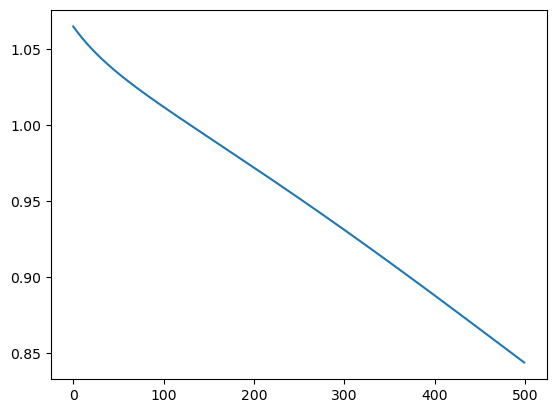

Network: partial_sigmoid
Epoch [1 / 500] Loss: 1.1132  Accuracy: 32.50 %
Epoch [51 / 500] Loss: 1.0922  Accuracy: 45.83 %
Epoch [101 / 500] Loss: 1.0777  Accuracy: 36.67 %
Epoch [151 / 500] Loss: 1.0637  Accuracy: 36.67 %
Epoch [201 / 500] Loss: 1.0488  Accuracy: 36.67 %
Epoch [251 / 500] Loss: 1.0324  Accuracy: 36.67 %
Epoch [301 / 500] Loss: 1.0143  Accuracy: 41.67 %
Epoch [351 / 500] Loss: 0.9946  Accuracy: 60.00 %
Epoch [401 / 500] Loss: 0.9732  Accuracy: 69.17 %
Epoch [451 / 500] Loss: 0.9506  Accuracy: 70.00 %


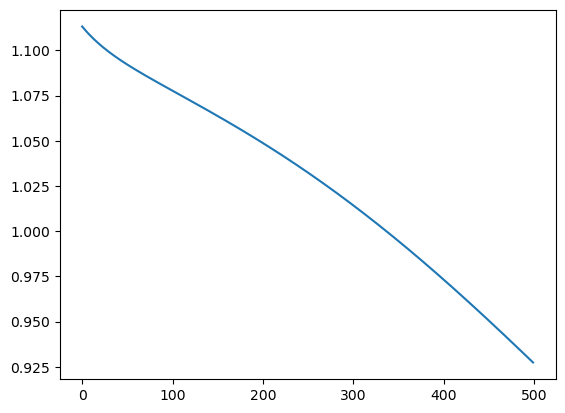

Network: zeroth_sigmoid
Epoch [1 / 500] Loss: 1.1590  Accuracy: 32.50 %
Epoch [51 / 500] Loss: 1.1575  Accuracy: 32.50 %
Epoch [101 / 500] Loss: 1.1562  Accuracy: 32.50 %
Epoch [151 / 500] Loss: 1.1549  Accuracy: 32.50 %
Epoch [201 / 500] Loss: 1.1537  Accuracy: 32.50 %
Epoch [251 / 500] Loss: 1.1526  Accuracy: 32.50 %
Epoch [301 / 500] Loss: 1.1515  Accuracy: 32.50 %
Epoch [351 / 500] Loss: 1.1505  Accuracy: 32.50 %
Epoch [401 / 500] Loss: 1.1496  Accuracy: 32.50 %
Epoch [451 / 500] Loss: 1.1488  Accuracy: 32.50 %


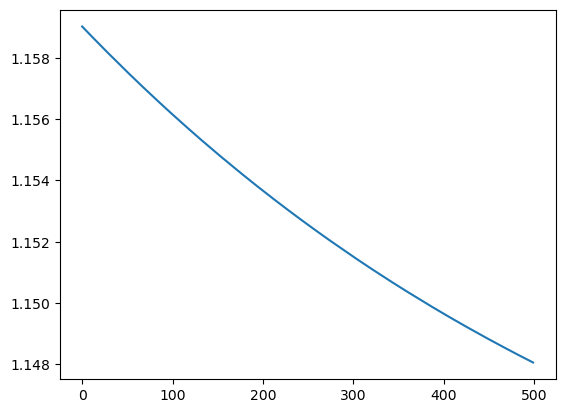

Network: standard_relu
Epoch [1 / 500] Loss: 0.9843  Accuracy: 50.00 %
Epoch [51 / 500] Loss: 0.7690  Accuracy: 84.17 %
Epoch [101 / 500] Loss: 0.6502  Accuracy: 93.33 %
Epoch [151 / 500] Loss: 0.5594  Accuracy: 94.17 %
Epoch [201 / 500] Loss: 0.4953  Accuracy: 95.83 %
Epoch [251 / 500] Loss: 0.4480  Accuracy: 96.67 %
Epoch [301 / 500] Loss: 0.4102  Accuracy: 97.50 %
Epoch [351 / 500] Loss: 0.3780  Accuracy: 97.50 %
Epoch [401 / 500] Loss: 0.3497  Accuracy: 97.50 %
Epoch [451 / 500] Loss: 0.3244  Accuracy: 97.50 %


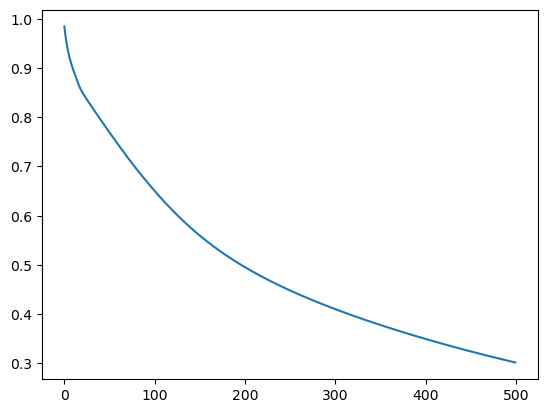

Network: partial_relu
Epoch [1 / 500] Loss: 1.3623  Accuracy: 9.17 %
Epoch [51 / 500] Loss: 1.0674  Accuracy: 39.17 %
Epoch [101 / 500] Loss: 1.0142  Accuracy: 40.83 %
Epoch [151 / 500] Loss: 0.9468  Accuracy: 48.33 %
Epoch [201 / 500] Loss: 0.8838  Accuracy: 50.83 %
Epoch [251 / 500] Loss: 0.8345  Accuracy: 64.17 %
Epoch [301 / 500] Loss: 0.7922  Accuracy: 74.17 %
Epoch [351 / 500] Loss: 0.7547  Accuracy: 83.33 %
Epoch [401 / 500] Loss: 0.7198  Accuracy: 87.50 %
Epoch [451 / 500] Loss: 0.6864  Accuracy: 90.83 %


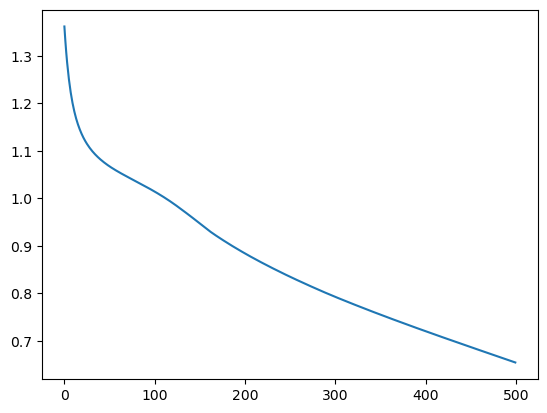

Network: zeroth_relu
Epoch [1 / 500] Loss: 1.0028  Accuracy: 32.50 %
Epoch [51 / 500] Loss: 0.9937  Accuracy: 32.50 %
Epoch [101 / 500] Loss: 0.9915  Accuracy: 32.50 %
Epoch [151 / 500] Loss: 0.9933  Accuracy: 32.50 %
Epoch [201 / 500] Loss: 0.9971  Accuracy: 32.50 %
Epoch [251 / 500] Loss: 1.0019  Accuracy: 33.33 %
Epoch [301 / 500] Loss: 1.0069  Accuracy: 34.17 %
Epoch [351 / 500] Loss: 1.0117  Accuracy: 35.83 %
Epoch [401 / 500] Loss: 1.0161  Accuracy: 41.67 %
Epoch [451 / 500] Loss: 1.0201  Accuracy: 45.00 %


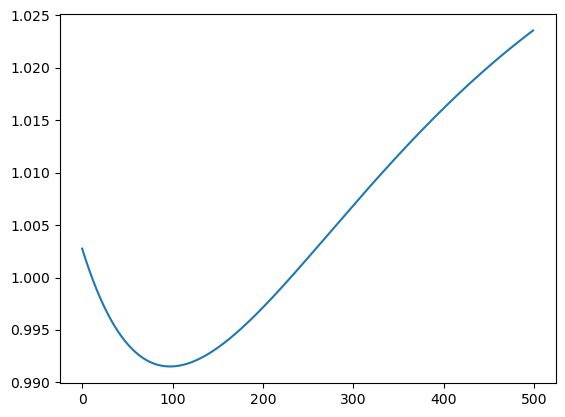

In [9]:
# Training Constants
LR = 0.01
NUM_EPOCH = 500

# Loss function
loss_func = torch.nn.CrossEntropyLoss()

# Train each network and plot the loss
for name, network in networks:
    print(f"Network: {name}\n=========")
    # Optimiser
    optimiser = torch.optim.SGD(network.parameters(), lr=LR)

    # store all losses for visualisation
    all_losses = []

    # train a neural network
    for epoch in range(NUM_EPOCH):
        # Perform forward pass
        Y_pred = network(X)
        # Compute loss
        loss = loss_func(Y_pred, Y)
        all_losses.append(loss.item())

        # print progress
        if epoch % 50 == 0:
            # convert three-column predicted Y values to one column for comparison
            _, predicted = torch.max(torch.nn.functional.softmax(Y_pred,1), 1)
            # calculate and print accuracy
            total = predicted.size(0)
            correct = predicted.data.numpy() == Y.data.numpy()
            # Print
            print('Epoch [%d / %d] Loss: %.4f  Accuracy: %.2f %%'
                % (epoch + 1, NUM_EPOCH, loss.item(), 100 * sum(correct)/total))

        # Clear the gradients before running the backward pass.
        network.zero_grad()
        # Perform backward pass
        loss.backward()
        # Step optimiser
        optimiser.step()

    # Plot
    plt.figure()
    plt.plot(all_losses)
    plt.show()